# Amazon Product Sentiment Analysis

Project: Amazon product recommender system   
Team: The Mean Squares  

This notebook gives a descripton of    
a. Performing the sentiment analysis using the following techniques: Logistic regression, Logistic regression with TFIDF vectorizer and Logistic regression with TFIDF vectorizer and n-grams techniques
b. Analysing the accuracy of the models and determining the best approach    
c. Identifying the highest-used words in each set of reviews, when grouped by rating

     
## Importing the libraries     
    
First step is to import all the libraries required

In [3]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction
import re

## Reading the data

Now, we are reading the reviews_merged.json file into dataframe and adding new columns to perform the efficiency of helpfulness metrics     


In [4]:
#Read the file and add new columns helpfulnessnumerator and helpfulnessdenominator
reviews = pd.read_json('reviews_merged.json')
reviews[['HelpfulnessNumerator','HelpfulnessDenominator']] = pd.DataFrame(reviews.helpful.values.tolist(), index = reviews.index)

## Data preprocessing 

We remove the duplicates if any, based on the reviewerID, productID (asin) and unix timestamp. Adding the upvote metrics to analyze the dataset    
     

In [5]:
#Cleaning the data by eliminating duplicates
reviews.drop_duplicates(subset=['reviewerID', 'asin','unixReviewTime'],inplace=True)

#Adding the helpfulness and upvote percentages for metrics
reviews['Helpful %'] = np.where(reviews['HelpfulnessDenominator'] > 0, reviews['HelpfulnessNumerator'] / reviews['HelpfulnessDenominator'], -1)
reviews['% Upvote'] = pd.cut(reviews['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
reviews['Id'] = reviews.index;
reviews

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,HelpfulnessNumerator,HelpfulnessDenominator,Helpful %,% Upvote,Id
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,3,4,0.750000,60-80%,0
1,7806397051,"[1, 1]",3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,1,1,1.000000,80-100%,1
2,7806397051,"[0, 1]",4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,0,1,0.000000,Empty,2
3,7806397051,"[2, 2]",2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,2,2,1.000000,80-100%,3
4,7806397051,"[0, 0]",3,"It was a little smaller than I expected, but t...","10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800,0,0,-1.000000,Empty,4
5,7806397051,"[1, 2]",5,"I was very happy to get this palette, now I wi...","04 15, 2013",A3BTN14HIZET6Z,"S. M. Randall ""WildHorseWoman""",Very nice palette!,1365984000,1,2,0.500000,40-60%,5
6,7806397051,"[1, 3]",1,PLEASE DONT DO IT! this just rachett the palet...,"08 16, 2013",A1Z59RFKN0M5QL,"tasha ""luvely12b""",smh!!!,1376611200,1,3,0.333333,20-40%,6
7,7806397051,"[0, 1]",2,"Chalky,Not Pigmented,Wears off easily,Not a Co...","09 4, 2013",AWUO9P6PL1SY8,TreMagnifique,"Chalky, Not Pigmented, Wears off easily, Not a...",1378252800,0,1,0.000000,Empty,7
8,9759091062,"[0, 0]",2,Did nothing for me. Stings when I put it on. I...,"07 13, 2014",A3LMILRM9OC3SA,NaN,"no Lightening, no Brightening,......NOTHING",1405209600,0,0,-1.000000,Empty,8
9,9759091062,"[0, 0]",3,I bought this product to get rid of the dark s...,"12 27, 2013",A30IP88QK3YUIO,Amina Bint Ibraheem,Its alright,1388102400,0,0,-1.000000,Empty,9


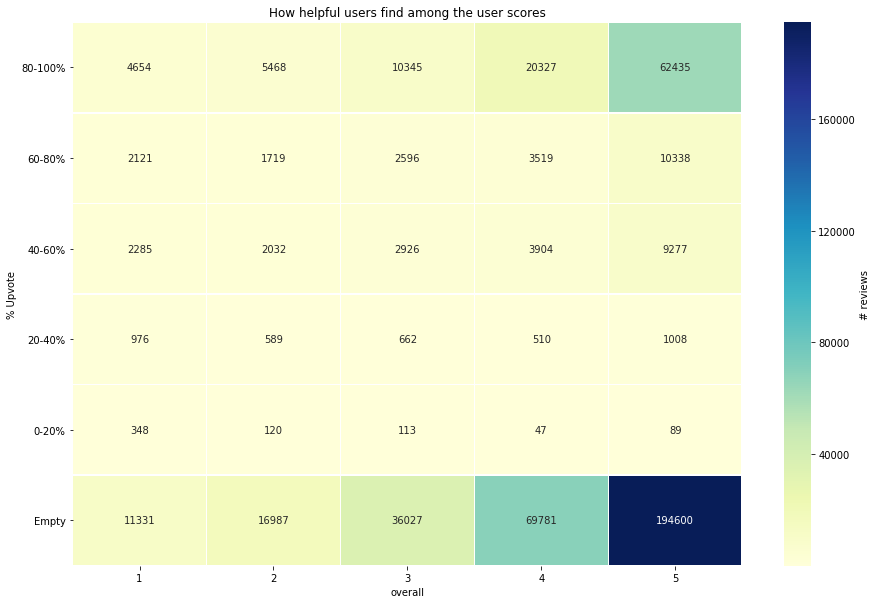

In [6]:
df_s = reviews.groupby(['overall', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among the user scores')
plt.show()


Removing the rating of 3, and convert the reviews into binary, 1- positive, 0- negative


In [7]:
df =  reviews[reviews['overall'] != 3]
X = df['reviewText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['overall'].map(y_dict)

Performing logistic regression on word count:

In [8]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 115341
# train records: 318349
# test records: 106117
Model Accuracy: 0.9335921671362741

-Top 20 positive-
Coefficient          Word
   2.514600    pleasantly
   2.511411         voila
   2.247089         habit
   2.217369         saves
   2.117423   compliments
   2.065625      exceeded
   2.054146       softest
   2.030774     subscribe
   1.996177        intent
   1.898054          bzzz
   1.870532   reservation
   1.869156           190
   1.849694   transformed
   1.847207         comet
   1.828497         loves
   1.815839         evens
   1.811722        highly
   1.807103  apprehensive
   1.806595     skeptical
   1.789965     thickener

-Top 20 negative-
Coefficient            Word
  -2.096658         defeats
  -2.100043             dud
  -2.107460           waste
  -2.163246          poorly
  -2.175272    unflattering
  -2.225249        goodwill
  -2.262640             o_o
  -2.271387      downgraded
  -2.271431            poor
  -2.413179         useless
  -2.41

It can be observed that the words with highest positive and negative coefficient don't make sense (such as 190 and 0_0), even if the accuracy is high. Baseline accuracy of the model is as follows:

In [9]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 115341
# train records: 318349
# test records: 106117
Model Accuracy: 0.79635685139987


TF-IDF vectorizer is added to logistic regression to improve the model accuracy

In [10]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 115341
# train records: 318349
# test records: 106117
Model Accuracy: 0.9362401877173309

-Top 20 positive-
Coefficient         Word
  12.899817         love
  11.274942        great
  10.658143      perfect
   8.761444       highly
   8.339233      amazing
   7.689518  compliments
   7.547291  comfortable
   7.474470        loves
   7.394395      pleased
   7.253354    excellent
   7.087920         best
   7.062837         nice
   6.859655         glad
   6.559846      awesome
   6.450318    perfectly
   6.182394         easy
   6.111311        helps
   5.886704        works
   5.710404       little
   5.602147        happy

-Top 20 negative-
Coefficient            Word
  -4.986251            didn
  -4.999510           hopes
  -5.075813         cheaply
  -5.202377   uncomfortable
  -5.707273           awful
  -5.841036       returning
  -5.906482          poorly
  -5.992559           shame
  -5.996539           broke
  -6.032897           worse
  -6.101499        terrible


Accuracy with tfidf has increased from 79.5 to 93.6. Logistic regression is now performed on TFIDF + n-grams. It can also be observed that words that don't indicate polarity of the sentiment are removed.

In [20]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 1399772
# train records: 55402
# test records: 18468
Model Accuracy: 0.9860298895386614

-Top 20 positive-
Coefficient         Word
   1.955933  comfortable
   1.742090          fit
   1.444603         size
   1.357627       colors
   1.253705        brush
   1.240617        great
   1.219507        price
   1.183615         wear
   1.085954      perfect
   1.036946         warm
   0.947524           34
   0.945416    recommend
   0.900329           ve
   0.840110         pair
   0.815484        tight
   0.807658        stays
   0.787403    expensive
   0.748784      regular
   0.743777        pairs
   0.736027       bought

-Top 20 negative-
Coefficient         Word
  -1.026397      tanning
  -1.030792         tree
  -1.032944     tea tree
  -1.038905         pura
  -1.072709       lotion
  -1.089293         para
  -1.092551        haven
  -1.159800        argan
  -1.167655           es
  -1.187189          oil
  -1.187743  conditioner
  -1.216978         item
  -1.283853 

It can be observed that accuracy of LR increased with n-grams to 98.6

# Upvote prediction

Analysing the pattern of downvotes by users to predict upvotes of the products

In [21]:
df = df[df['overall'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['reviewText']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1    72773
0     1097
Name: % Upvote, dtype: int64


It can be observed that the upvotes are skewed towards positive side. To avoid it, resampling the data has to be performed. 

In [22]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.loc[under_sample_indices, :]
X_u = under_sample_data['reviewText']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  2194


Now, the similar operations as above are performed on the resampled data to measure accuracy of the model

In [23]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 10998
# train records: 1645
# test records: 549
Model Accuracy: 0.5774134790528234

-Top 20 positive-
Coefficient         Word
   0.985616         slip
   0.925289  comfortable
   0.893796        pairs
   0.859238          mix
   0.834367      putting
   0.825174      pleased
   0.821810         warm
   0.806312     dandruff
   0.804728      mascara
   0.799578      forever
   0.792720       stones
   0.785512  moisturizer
   0.781844  beautifully
   0.781541        lasts
   0.776866   absolutely
   0.753448      regular
   0.753269     cleaning
   0.743428       second
   0.738676          bag
   0.729880          fit

-Top 20 negative-
Coefficient      Word
  -0.766586      idea
  -0.773638    smells
  -0.776257      know
  -0.777615   results
  -0.783954   organic
  -0.794479   pimples
  -0.805905        ll
  -0.808540    taking
  -0.816182    called
  -0.829431  probably
  -0.837078    buying
  -0.874064     feels
  -0.882610    wouldn
  -0.885033      runs
  -0.900536 

57.7% is the accuracy of the model. Now, the same is performed with n-grams and tf-idf vectorizer

In [24]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 85659
# train records: 1645
# test records: 549
Model Accuracy: 0.6156648451730419

-Top 20 positive-
Coefficient         Word
   1.530252  comfortable
   1.479148          fit
   1.409056         size
   0.893714        price
   0.875360           34
   0.863019          bag
   0.842406         wear
   0.840722         cute
   0.821837        great
   0.812170         ring
   0.712774       colors
   0.702499         pair
   0.675764         warm
   0.671117    beautiful
   0.638585        style
   0.626969      pleased
   0.622711      perfect
   0.619346      mascara
   0.618383        small
   0.615437       bought

-Top 20 negative-
Coefficient         Word
  -0.616608         dove
  -0.617007         hair
  -0.636135          say
  -0.638448    love love
  -0.665454      friends
  -0.671087           la
  -0.671131          que
  -0.671918         know
  -0.681744       smells
  -0.717846  conditioner
  -0.727255    body wash
  -0.738330         good
  -0.746810      

The accuracy has improved to 61.56, but still has some words which don't indicate polarity in the top 10/20.

# Effect of non-contextual features


In [27]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['reviewText'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['reviewText'].iloc[:100:20])

Downvote score 5 comments examples:
355      I have shoulder length thick hair, but the end...
7025     No, I don't use this stuff, but my wife and ma...
12280    I use these all the time - usually twice a wee...
14883    You can put away all of your Dove bars now--be...
15741    im very ashamed to say but ,i went a few days ...
Name: reviewText, dtype: object
Upvote score 5 comments examples
130260    This is such a great investment for any makeup...
341618    I had ordered a couple wallets and been very d...
146394    This has to be tried. It has literally saved m...
388282    I LOVE this shirt.  I've bought about five fla...
296772    I'm 5'3&#34; at 160 and got these in Large. Th...
Name: reviewText, dtype: object


Above are the samples of the reviews that received downvotes and upvotes. The possible features have to be extracted from these reviews.

In [26]:
under_sample_data['word_count'] = under_sample_data['reviewText'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['reviewText'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'reviewText'])]
y_num = under_sample_data['% Upvote']

% Upvote                   0          1
word_count        100.304467  94.027347
capital_count      22.326345  15.863263
question_mark       0.089335   0.055606
exclamation_mark    1.078396   0.994531
punctuation        16.536007  15.941659


# Training the model to predict

The model is now trained to predict upvotes

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.4990892531876138
SVM accuracy: 0.5701275045537341


Accuracy is lower than the count feature and so, it can be determined that these non-contextual features are not the right choice to perform the prediction

# Study of user behavior

The user behavior has to be analyzed to improve the model performance and understand the underlying reasons for the bad or good reviews. This also gives importance to word choices of a user when giving the reviews.

In [30]:
df_user = reviews.groupby(['reviewerID']).agg({'overall':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Rating count', 'Rating mean']
df_user = df_user.sort_values(by = 'Rating count', ascending = False)
print(df_user.head(10))

                Rating count  Rating mean
reviewerID                               
A2V5R832QCSOMX           265     4.362264
ALNFHVS3SC4FV            204     4.034314
AKMEY1BSHSDG7            201     4.592040
A34BZM6S9L7QI4           190     4.457895
AENH50GW3OKDA            168     4.619048
A1UQBFCERIP7VJ           165     4.709091
ALQGOMOY1F5X9            160     2.293750
A3KEZLJ59C1JVH           154     3.662338
A3NHUQ33CFH3VM           153     4.496732
A2J4XMWKR8PPD0           146     5.000000


Count of ratings is considered to select the user and user with the id ALQGOMOY1F5X9 is randomly chosen

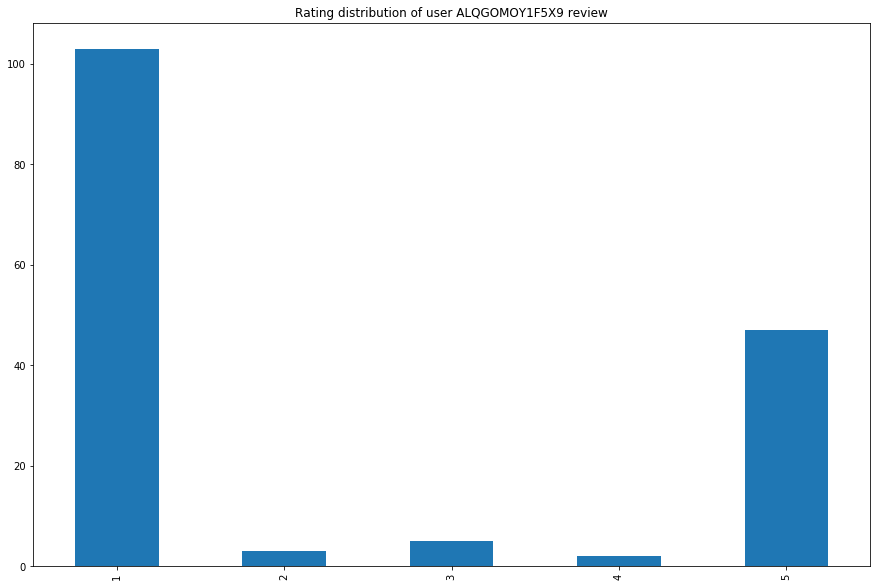

In [31]:
def plot_user(reviewerID):
    df_1user = reviews[reviews['reviewerID'] == reviewerID]['overall']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Rating distribution of user {} review'.format(reviews[reviews['reviewerID'] == reviewerID]['reviewerID'].iloc[0]))
    plt.show()

plot_user('ALQGOMOY1F5X9')

It can be observed that the user is skeptical of most of the products and hence, reviews are biased towards negative

In [32]:
print(df_user[(df_user['Rating mean']<3.5) & (df_user['Rating mean']>2.5)].head())

                Rating count  Rating mean
reviewerID                               
A1RRMZKOMZ2M7J           125     3.272000
A2P739KOM4U5JB           117     3.487179
ARYSDAZNRXN6G            115     3.495652
A2LW5AL0KQ9P1M           107     3.261682
APYKGTU0LFICH             82     2.865854


Now, one of the users with mean rating near 3 (A1RRMZKOMZ2M7J) is chosen to perform the analysis

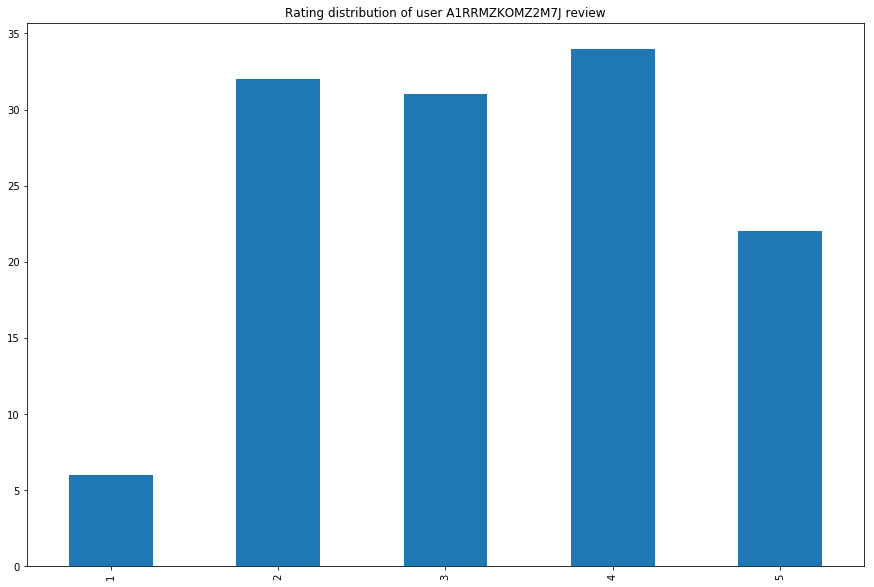

In [33]:
plot_user('A1RRMZKOMZ2M7J')

Most popular words used by the user for different ratings are observed. (2-grams and 3-grams are chosen for analysis)

In [ ]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2P739KOM4U5JB')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    #test = test.sort_values('Count', ascending=False)
    print(test)

Now, the popular words for all users are observed

In [ ]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

Now, only the adjectives are taken into consideration, as those express opinion and nouns don't.

In [38]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = reviews[(reviews['reviewerID'] == userid) & (reviews['overall'] == score)]['reviewText']
    else:
        df = reviews[reviews['overall'] == score]['reviewText']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

In [39]:
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2P739KOM4U5JB')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
    Count  Occur %       Phrase
0     8.0  114.29%         hair
2     6.0   85.71%          dry
1     6.0   85.71%         good
3     4.0   57.14%         long
4     3.0   42.86%        great
5     3.0   42.86%    immediate
6     3.0   42.86%       sticky
12    2.0   28.57%        silky
15    2.0   28.57%  disclaimer-
14    2.0   28.57%       strong
13    2.0   28.57%      several
8     2.0   28.57%         fine
11    2.0   28.57%          hot
10    2.0   28.57%          big
9     2.0   28.57%         hard
7     2.0   28.57%      shampoo
16    2.0   28.57%        short
score 2 reviews most popular adjectives word:
   Count Occur %   Phrase
0   18.0  78.26%    great
1   14.0  60.87%     good
2   14.0  60.87%     hair
3   10.0  43.48%      dry
4    8.0  34.78%   little
5    6.0  26.09%     flat
6    6.0  26.09%     soft
7    6.0  26.09%  several
score 3 reviews most popular adjectives word:
   Count Occur %  Phrase
0   15.0   75.0%     dry
1 

Sentiment analysis is performed using logistic regression and support vector machines. The usage of non-contextual features in reviews is observed. Also, the user behavior is analyzed and the popular words used by the users are determined. 